In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x44_DE.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,0.606309,0.606130,0.035808,-1.068212,-1.068212,-0.986813,0.287230,-0.133221,-0.047127,0.205624,-0.867990,-0.383964,-0.069702,-0.125211,-0.37762,2.003373,0.863576,0.978751,0.482775,0.755624,-0.927085,-0.019008,-0.911567,-0.003879,-0.006719,2.781231,-0.870794,11.590255,-0.36524,-1.302022,-0.251026,-0.105686,-0.144603,-0.125725,-0.113695,-0.319218,-0.034935,-0.152178,-0.088896,-0.051386,2.401683,-0.786521,-0.941810,0.0
1,1.847046,0.774764,1.783361,0.837623,0.837623,-0.986813,1.380044,2.362517,2.382457,-0.101756,-0.867990,0.696178,-0.069702,-0.125211,-0.37762,0.842595,0.863576,0.978751,0.482775,0.755624,0.605102,-0.019008,1.097012,-0.003879,-0.006719,-0.359553,-0.870794,-0.086279,-0.36524,0.768036,-0.251026,-0.105686,-0.144603,-0.125725,-0.113695,-0.319218,-0.034935,-0.152178,-0.088896,-0.051386,-0.416375,1.271422,-0.941810,1.0
2,0.163188,-0.321359,-0.521897,0.837623,0.837623,-0.433996,0.617784,-0.133221,0.114845,-0.470743,0.922834,-0.383964,-0.069702,-0.125211,-0.37762,0.463565,-1.157976,-1.021711,0.482775,1.287329,-1.437814,-0.019008,1.097012,-0.003879,-0.006719,-0.359553,-0.870794,-0.086279,-0.36524,0.768036,-0.251026,-0.105686,-0.144603,-0.125725,-0.113695,-0.319218,-0.034935,-0.152178,-0.088896,-0.051386,2.401683,-0.786521,-0.941810,0.0
3,-0.037519,-0.456266,0.225909,-0.115295,-0.115295,-0.433996,-0.247858,-0.311488,0.195831,-0.472931,0.027422,-0.383964,-0.069702,-0.125211,1.23937,0.368808,0.863576,0.978751,0.482775,1.287329,1.115831,-0.019008,-0.911567,-0.003879,-0.006719,-0.359553,1.148377,-0.086279,-0.36524,-1.302022,-0.251026,-0.105686,6.915465,-0.125725,-0.113695,-0.319218,-0.034935,-0.152178,-0.088896,-0.051386,-0.416375,-0.786521,1.061786,0.0
4,1.117201,0.167680,1.963155,0.837623,0.837623,-0.986813,0.737218,1.827716,2.220485,2.561753,0.027422,-0.383964,-0.069702,-0.125211,-0.37762,0.131914,0.863576,0.978751,0.482775,0.755624,1.115831,-0.019008,-0.911567,-0.003879,-0.006719,-0.359553,1.148377,-0.086279,-0.36524,0.768036,-0.251026,-0.105686,-0.144603,-0.125725,-0.113695,-0.319218,-0.034935,-0.152178,-0.088896,-0.051386,-0.416375,1.271422,-0.941810,0.0


In [4]:
data.shape

(66449, 44)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    41777
0.0    24672
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(66449, 43)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.63370956 0.63762227 0.63950339 0.64040632 0.64278727]
0.6388057605307398


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[ 3699, 20973],
       [ 3028, 38749]])

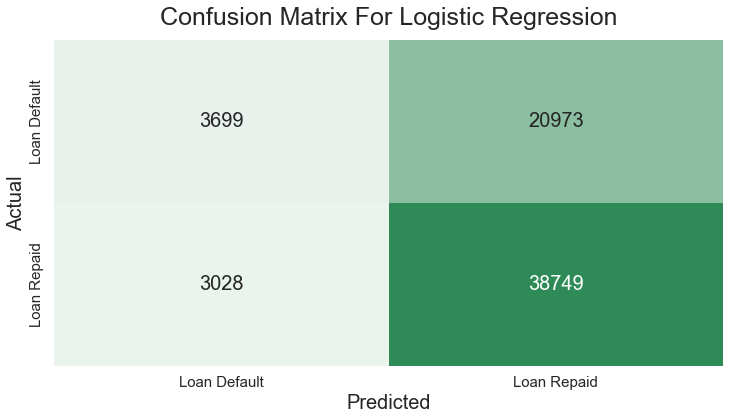

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.6388057006124999

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

38749
20973
3028
3699
0.6388057006124999


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    41777
0.0    24672
Name: loan_status_bin, dtype: int64

0.6287077307408689


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.6488228793409464

In [17]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [18]:
y_pred_prob

array([[0.37579718, 0.62420282],
       [0.41802749, 0.58197251],
       [0.28435653, 0.71564347],
       ...,
       [0.29416292, 0.70583708],
       [0.35738582, 0.64261418],
       [0.21047152, 0.78952848]])

In [19]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[24236,   436],
       [39753,  2024]])

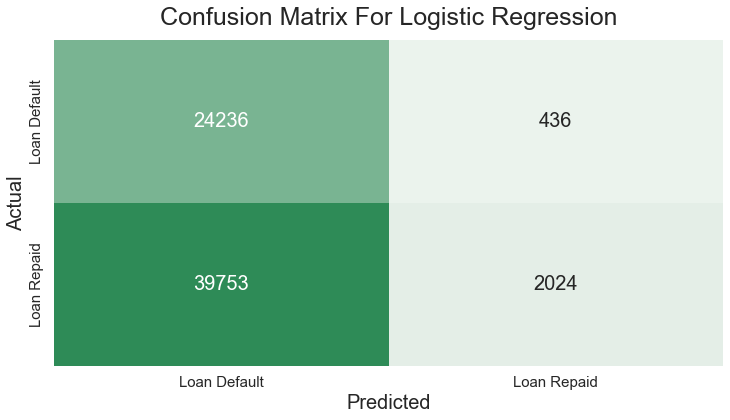

In [21]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [22]:
accuracy_score(y, y_pred_success)

0.39519029631747654

In [23]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

2024
436
39753
24236
0.39519029631747654


In [24]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8227642276422764

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 